#### importing libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import warnings

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, precision_recall_curve, roc_auc_score, f1_score , confusion_matrix
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectFromModel

# Imbalanced-learn for handling class imbalance correctly in pipelines
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline

# Model Explainability
import shap

# Configure settings for cleaner output
%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')


c:\Users\PC\BankMarketing\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Load and Prepare Data 

In [2]:
df = pd.read_csv('../data/eda_data.csv')
mapping = {"yes": 1, "no": 0}
df['y'] = df['y'].map(mapping)

X = df.drop(columns=['y'], axis=1)
y = df['y']

#### Train test split

In [3]:
# Stratified split to maintain target distribution
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)
X_validate, X_test, y_validate, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

print(f"Training set shape:   {X_train.shape}")
print(f"Validation set shape: {X_validate.shape}")
print(f"Test set shape:       {X_test.shape}")



Training set shape:   (27582, 19)
Validation set shape: (5911, 19)
Test set shape:       (5911, 19)


#### Define Preprocessor

In [4]:
# This preprocessor will be used for BOTH clustering and modeling
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ],
    remainder='passthrough'
)



#### Data Segmentation using Clustering 


--- Step 1: Segmenting Data with K-Means Clustering ---


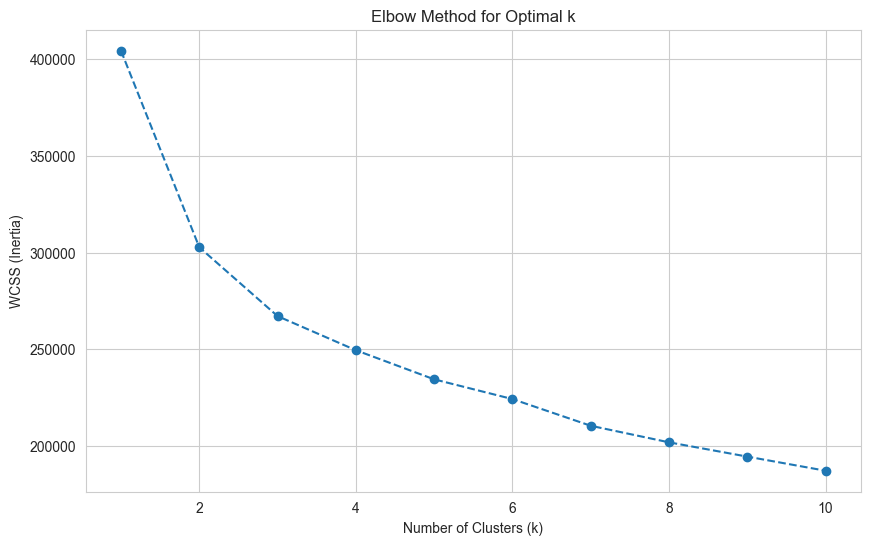

In [5]:
print("\n--- Step 1: Segmenting Data with K-Means Clustering ---")

# Preprocess the training data for clustering
# IMPORTANT: Fit the preprocessor ONLY on the training data
X_train_processed = preprocessor.fit_transform(X_train)

#Elbow Method to find the optimal number of clusters
wcss = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_train_processed)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.grid(True)
plt.show()

In [6]:
OPTIMAL_K = 3
print(f"\nSelected optimal number of clusters (k) = {OPTIMAL_K}")

# Fit K-Means with the optimal k
kmeans = KMeans(n_clusters=OPTIMAL_K, init='k-means++', random_state=42, n_init=10)
train_labels = kmeans.fit_predict(X_train_processed)

# Assign cluster labels to all datasets
X_train['cluster'] = train_labels
# Use the FITTED preprocessor and kmeans to assign clusters to val/test sets
X_validate['cluster'] = kmeans.predict(preprocessor.transform(X_validate))
X_test['cluster'] = kmeans.predict(preprocessor.transform(X_test))

print("\nCluster distribution in datasets:")
print("Training Set:\n", X_train['cluster'].value_counts(normalize=True))
print("\nValidation Set:\n", X_validate['cluster'].value_counts(normalize=True))
print("\nTest Set:\n", X_test['cluster'].value_counts(normalize=True))


Selected optimal number of clusters (k) = 3

Cluster distribution in datasets:
Training Set:
 cluster
1    0.664673
2    0.296860
0    0.038467
Name: proportion, dtype: float64

Validation Set:
 cluster
1    0.668922
2    0.291998
0    0.039080
Name: proportion, dtype: float64

Test Set:
 cluster
1    0.669937
2    0.287769
0    0.042294
Name: proportion, dtype: float64


#### Train a Specific Model for Each Segment 


---  Step 2: Training a Specialized Model for Each Segment ---

================== Training Model for Cluster 0 ==================
Data points in this segment: 1061
[LightGBM] [Info] Number of positive: 660, number of negative: 401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 1061, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.622055 -> initscore=0.498278
[LightGBM] [Info] Start training from score 0.498278
[LightGBM] [Info] Number of positive: 660, number of negative: 401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Numb

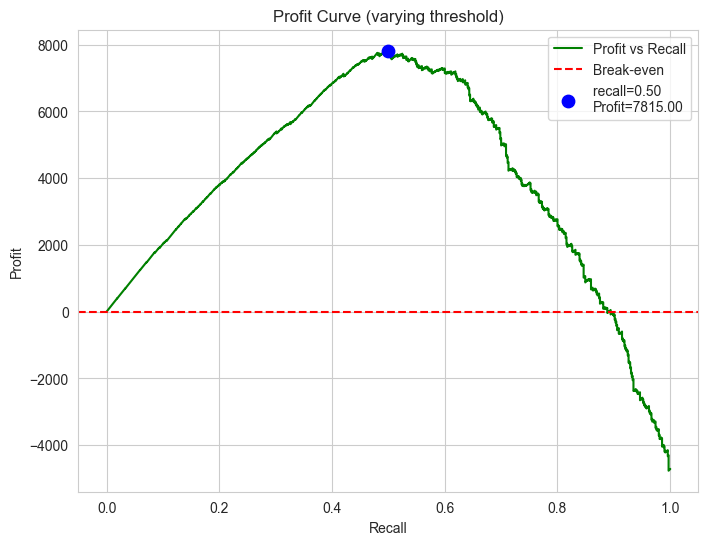

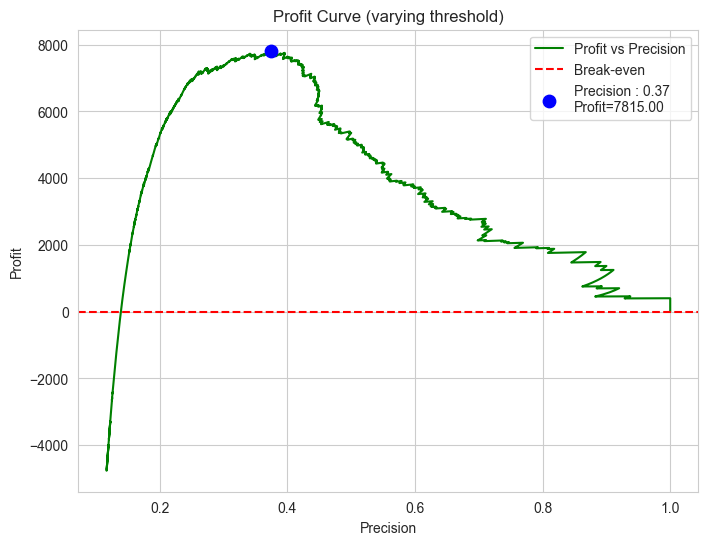

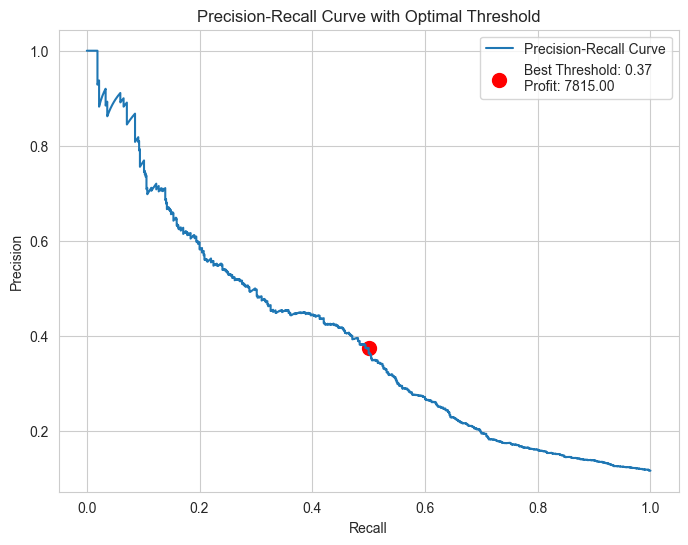


--- SHAP Summary for Cluster 0 ---


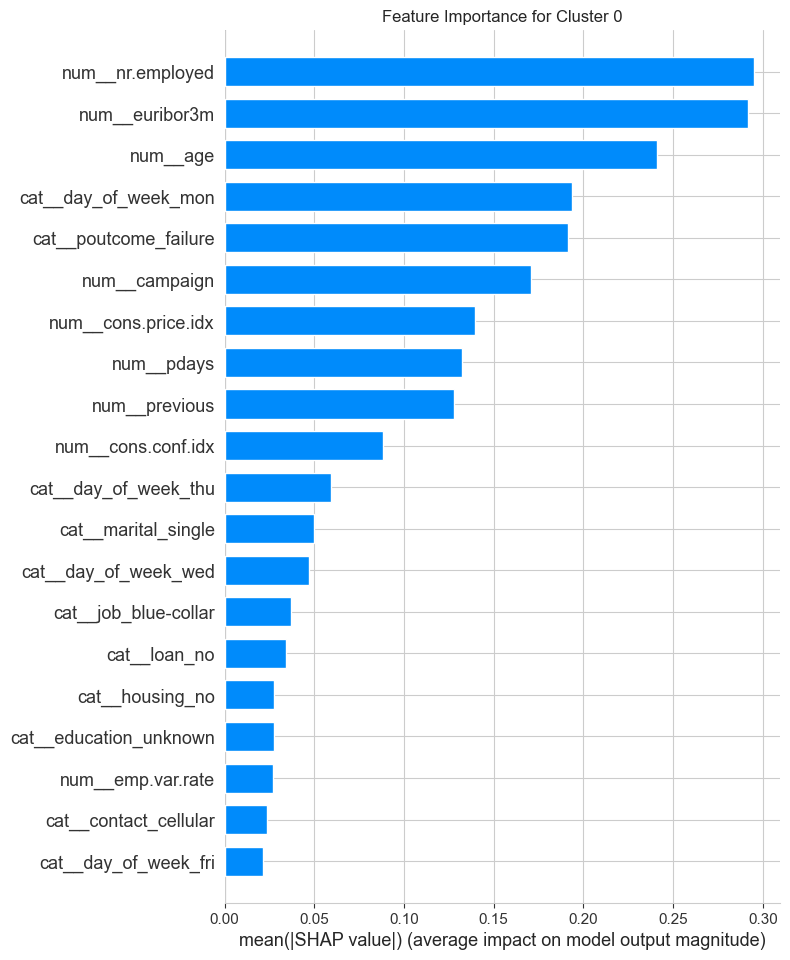


================== Training Model for Cluster 1 ==================
Data points in this segment: 18333
[LightGBM] [Info] Number of positive: 934, number of negative: 17399
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 242
[LightGBM] [Info] Number of data points in the train set: 18333, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.050946 -> initscore=-2.924692
[LightGBM] [Info] Start training from score -2.924692
[LightGBM] [Info] Number of positive: 934, number of negative: 17399
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 191
[LightGBM] [In

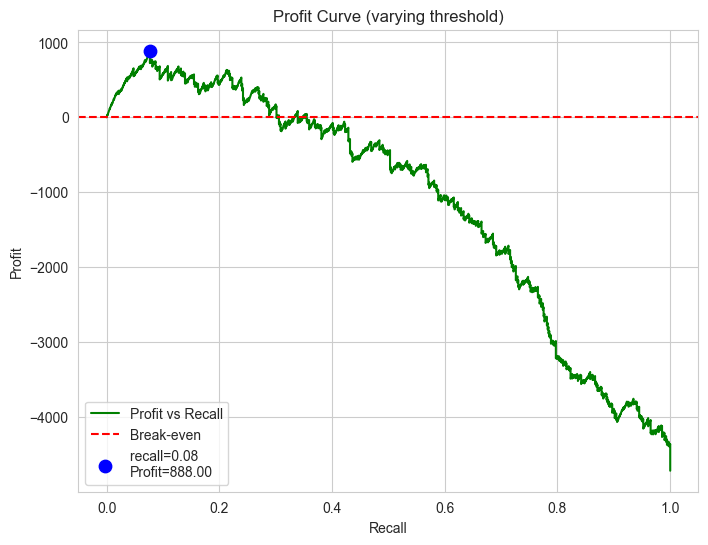

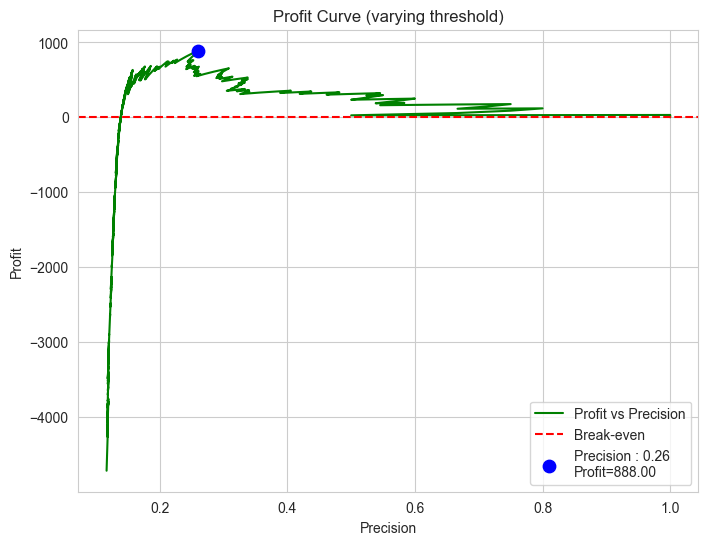

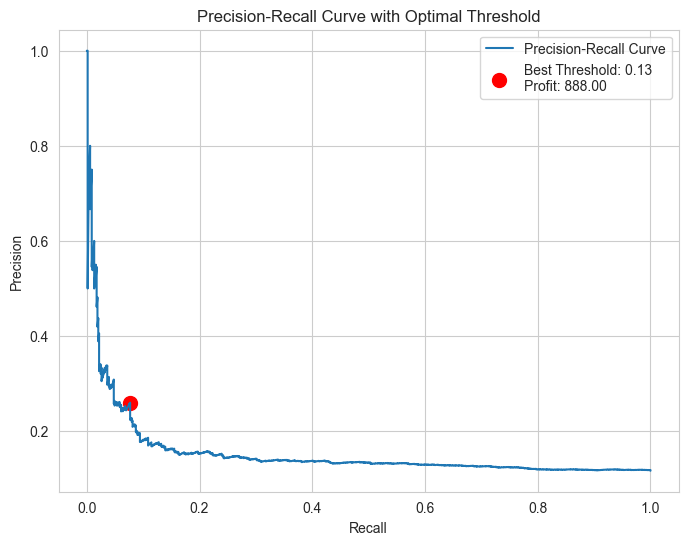


--- SHAP Summary for Cluster 1 ---


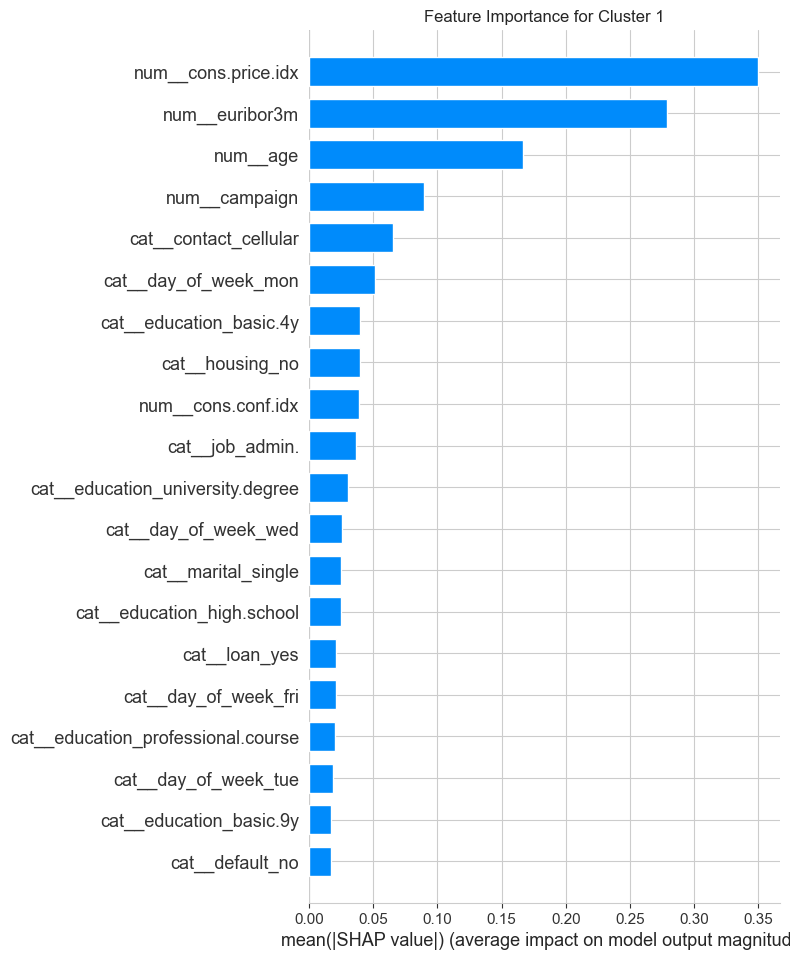


================== Training Model for Cluster 2 ==================
Data points in this segment: 8188
[LightGBM] [Info] Number of positive: 1625, number of negative: 6563
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 383
[LightGBM] [Info] Number of data points in the train set: 8188, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198461 -> initscore=-1.395940
[LightGBM] [Info] Start training from score -1.395940
[LightGBM] [Info] Number of positive: 1625, number of negative: 6563
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 329
[LightGBM] [Info

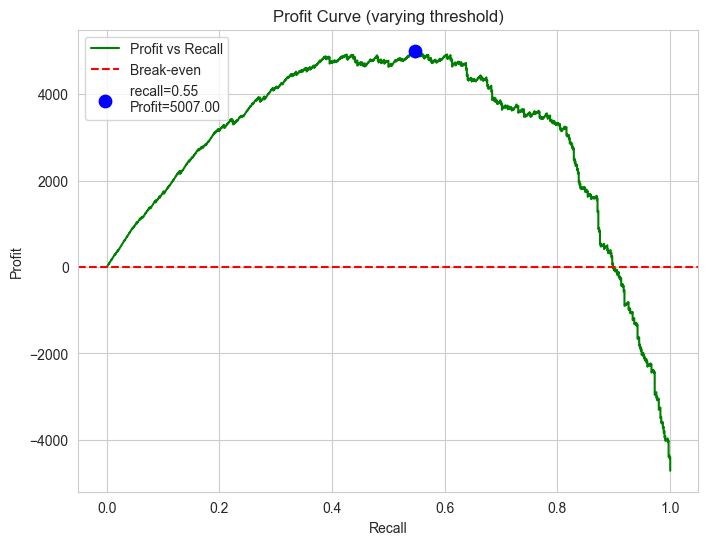

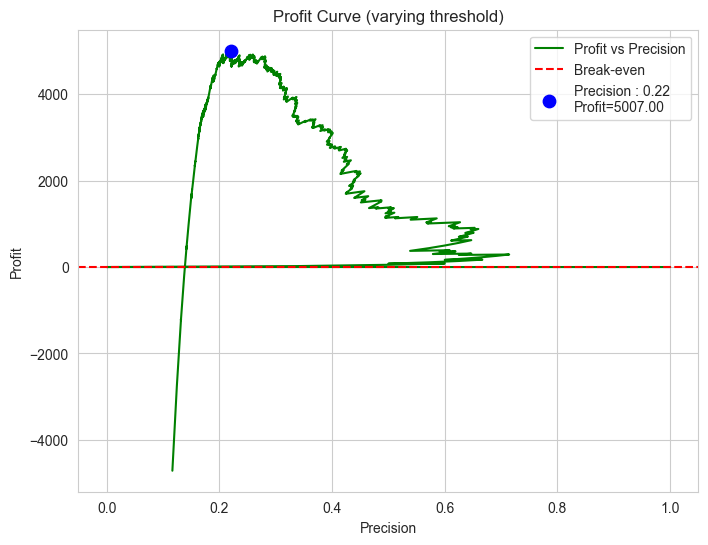

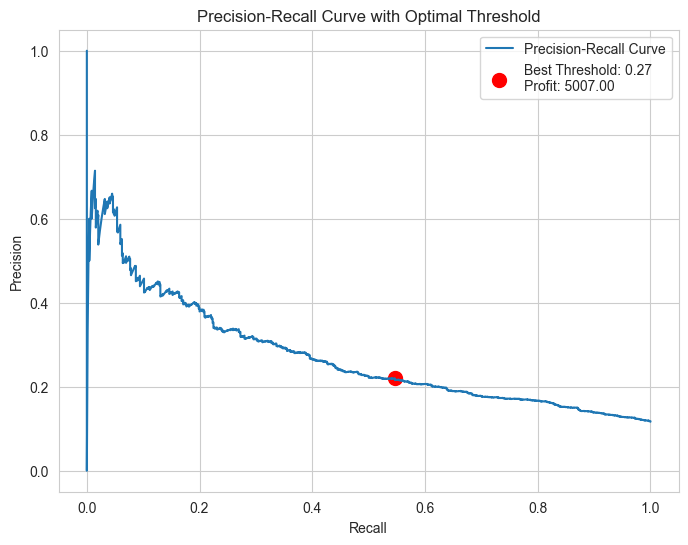


--- SHAP Summary for Cluster 2 ---


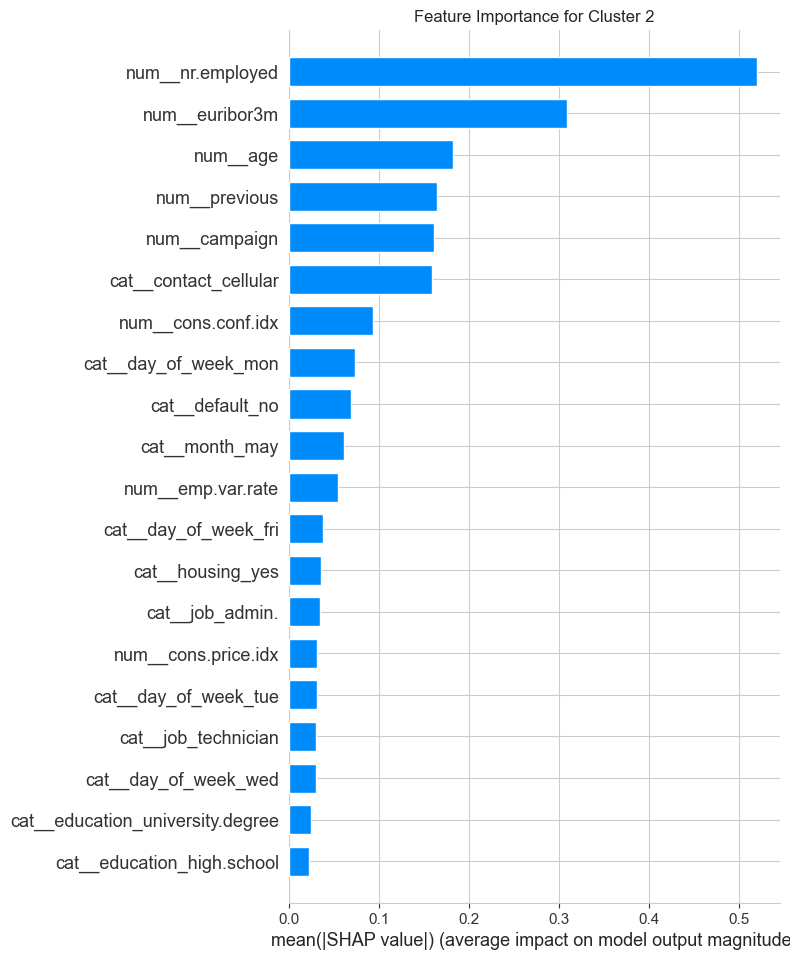

In [ ]:
print("\n---  Step 2: Training a Specialized Model for Each Segment ---")

segment_models = {}
segment_results = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for cluster_id in sorted(X_train['cluster'].unique()):
    print(f"\n================== Training Model for Cluster {cluster_id} ==================")

    # Filter data for the current cluster
    train_mask = (X_train['cluster'] == cluster_id)
    validate_mask = (X_validate['cluster'] == cluster_id)
    test_mask = (X_test['cluster'] == cluster_id)

    X_train_c = X_train[train_mask].drop(columns=['cluster']).reset_index(drop=True)
    y_train_c = y_train[train_mask].reset_index(drop=True)
    
    X_validate_c = X_validate[validate_mask].drop(columns=['cluster']).reset_index(drop=True)
    y_validate_c = y_validate[validate_mask].reset_index(drop=True)
    
    X_test_c = X_test[test_mask].drop(columns=['cluster']).reset_index(drop=True)
    y_test_c = y_test[test_mask].reset_index(drop=True)

    print(f"Data points in this segment: {len(X_train_c)}")
    if len(X_train_c) < 50: # Skip if segment is too small to be meaningful
        print("Segment too small, skipping...")
        continue

    # --- A. Hyperparameter Tuning for the Segment ---
    tuning_pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('feature_selection', SelectFromModel(
            lgb.LGBMClassifier(n_estimators=200,random_state=42),
            max_features=31,   # or median but it select different number of features for each fold , which make problems
            threshold=-np.inf  # ensure max_features is used
        )),
        ('classifier', lgb.LGBMClassifier(random_state=42))
    ])

    param_grid = {
    'classifier__n_estimators': [500, 1000, 1500],   
    'classifier__learning_rate': [0.01, 0.05, 0.1], 
    'classifier__max_depth': [-1, 6, 10],           
    'classifier__num_leaves': [31, 63, 127],        
    'classifier__min_child_samples': [10, 20, 50],  
    'classifier__subsample': [0.7, 0.8, 1.0],       
    'classifier__colsample_bytree': [0.7, 0.8, 1.0],
    'classifier__reg_alpha': [0, 0.1, 1],           
    'classifier__reg_lambda': [0, 0.1, 1]           
    }

    random_search = RandomizedSearchCV(
    tuning_pipeline,
    param_distributions=param_grid,
    n_iter=10,  
    cv=skf,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42
    )

    random_search.fit(X_train_c, y_train_c)
    final_model_pipeline = random_search.best_estimator_
    segment_models[cluster_id] = final_model_pipeline
    print(f" Best parameters found for Cluster {cluster_id}")

    # Find Optimal Threshold for Max Profit
    print("\n--- Finding Optimal Threshold on Validation Set ---")

    # Get prediction probabilities on the validation data
    y_val_proba = final_model_pipeline.predict_proba(X_validate)[:, 1]

    # Define business metrics

    # marketing_cost per call
    # Affected by TP and FP --> we make call to both , 1.actual true and predicted true , 2. actual false but predicted true)
    call_cost = 5.0  # (including labor & infrastructure)

    # this cost are affect after customer Acquisition (agree for subscription)(only Affected by TP-actual true and predicted true )
    # Onboarding & KYC verification cost
    onboarding_cost = 5
    #Account management costs(back-office ops, compliance)
    acc_cost = 15
    # Other overheads(like customer support): 
    other_overheads = 10
    total_customer_cost = onboarding_cost + acc_cost + other_overheads  # Total acquisition cost

    # calculating revenue per costomer (only Affected by TP-actual true and predicted true )
    # Average deposit amount = 3000
    # Interest spread(Interest Earned by Bank on Loans or Investments − Interest Paid to Customer on Deposit) = 2.2% annually
    # Customer holds deposit for 1 year
    subscription_revenue = 66 # (3000 * 0.022)

    # Calculate profit for every possible threshold 
    precisions, recalls, thresholds = precision_recall_curve(y_validate, y_val_proba)

    # To avoid division by zero
    valid_precisions = np.maximum(precisions, 1e-8)
    calls_made = (recalls * sum(y_validate)) / valid_precisions
    #total profit = total_revenue - total_cost(cost of handling + marketing)
    profit = (recalls * sum(y_validate) * subscription_revenue) - (recalls * sum(y_validate) * total_customer_cost) - (calls_made * call_cost)


    # Find the threshold that corresponds to the maximum profit
    best_threshold = thresholds[np.argmax(profit)]
    print(f" Best Threshold for Max Profit: {best_threshold:.4f}")


    # True positives and predicted positives at each point
    total_pos = sum(y_validate)
    TP = recalls * total_pos
    pred_pos = np.divide(TP, np.maximum(precisions, 1e-8))  # calls made

    # === Find Best Point ===
    best_idx = np.argmax(profit)
    print(f" Best Threshold: {best_threshold}")
    print(f"Recall = {recalls[best_idx]:.3f}, Precision = {precisions[best_idx]:.3f}")
    print(f"Calls Made = {int(pred_pos[best_idx])}, True Positives = {int(TP[best_idx])}")
    print(f"Max Profit = ${profit[best_idx]:.2f}")

    # --- C. Final Evaluation on Test Set ---
    y_test_proba = final_model_pipeline.predict_proba(X_test_c)[:, 1]
    y_test_pred_optimized = (y_test_proba >= best_threshold).astype(int)
    report = classification_report(y_test_c, y_test_pred_optimized, output_dict=True, zero_division=0)
    print(f"\n---  Final Report on Test Set (Cluster {cluster_id}) ---")
    print(classification_report(y_test_c, y_test_pred_optimized, target_names=['No', 'Yes'], zero_division=0))

    max_idx = np.argmax(profit)
    max_recall = recalls[max_idx]
    max_precision = precisions[max_idx]
    max_profit = profit[max_idx]

    # === Profit Curve ===
    plt.figure(figsize=(8,6))
    plt.plot(recalls, profit, label="Profit vs Recall", color="green")
    plt.axhline(0, color="red", linestyle="--", label="Break-even")
    plt.scatter(max_recall, max_profit, color="blue", s=80, zorder=5, 
                label=f"recall={max_recall:.2f} \nProfit={max_profit:.2f}")
    plt.xlabel("Recall")
    plt.ylabel("Profit")
    plt.title("Profit Curve (varying threshold)")
    plt.grid(True)
    plt.legend()
    plt.show()


    # Plot
    plt.figure(figsize=(8,6))
    plt.plot(precisions, profit, label="Profit vs Precision", color="green")
    plt.axhline(0, color="red", linestyle="--", label="Break-even")
    plt.scatter(max_precision, max_profit, color="blue", s=80, zorder=5, 
                label=f"Precision : {max_precision:.2f} \nProfit={max_profit:.2f}")
    plt.xlabel("Precision")
    plt.ylabel("Profit")
    plt.title("Profit Curve (varying threshold)")
    plt.grid(True)
    plt.legend()
    plt.show()


    plt.figure(figsize=(8, 6))
    plt.plot(recalls, precisions, label="Precision-Recall Curve")
    plt.scatter(recalls[best_idx], precisions[best_idx], color='red', s=100,
                label=f"Best Threshold: {best_threshold:.2f}\nProfit: {max_profit:.2f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve with Optimal Threshold")
    plt.legend()
    plt.grid(True)
    plt.show()


    positive_class_report = report.get('1', {})
    segment_results.append({
        "Cluster ID": cluster_id,
        "Data Points": len(X_train_c),
        "Best Threshold": best_threshold,
        "Max Profit (Val)": max_profit,
        "Test F1 (Sub)": positive_class_report.get('f1-score', 0.0),
        "Test Recall (Sub)": positive_class_report.get('recall', 0.0),
        "Test Precision (Sub)": positive_class_report.get('precision', 0.0),
        "Test ROC AUC": roc_auc_score(y_test_c, y_test_proba) if len(np.unique(y_test_c)) > 1 else 0.0
    })

    #SHAP Explainability for the Segment ---
    print(f"\n--- SHAP Summary for Cluster {cluster_id} ---")
    X_test_preprocessed = final_model_pipeline.named_steps['preprocessor'].transform(X_test_c)
    selector = final_model_pipeline.named_steps['feature_selection']
    X_test_processed = selector.transform(X_test_preprocessed)
    
    all_features = final_model_pipeline.named_steps['preprocessor'].get_feature_names_out()
    feature_names = all_features[selector.get_support()]
    X_test_processed_df = pd.DataFrame(X_test_processed, columns=feature_names)

    explainer = shap.TreeExplainer(final_model_pipeline.named_steps['classifier'])
    shap_values = explainer.shap_values(X_test_processed_df)
    
    shap.summary_plot(shap_values, X_test_processed_df, plot_type="bar", show=False)
    plt.title(f"Feature Importance for Cluster {cluster_id}")
    plt.show()


### Final Summary of All Segmented Models 

In [8]:
print("\n==================  Final Summary of Segmented Models ==================")
summary_df = pd.DataFrame(segment_results)
print(summary_df.to_string())


==================  Final Summary of Segmented Models ==================
   Cluster ID  Data Points  Best Threshold  Max Profit (Val)  Test F1 (Sub)  Test Recall (Sub)  Test Precision (Sub)  Test ROC AUC
0           0         1061        0.365704            7815.0       0.786704           0.922078              0.685990      0.719900
1           1        18333        0.125156             888.0       0.076923           0.057592              0.115789      0.580391
2           2         8188        0.274732            5007.0       0.475716           0.555233              0.416122      0.755895



==================  Applying Segmented Models to Full Test Set ==================
--- Predicting for Cluster 0 ---
Applying threshold: 0.3657
--- Predicting for Cluster 1 ---
Applying threshold: 0.1252
--- Predicting for Cluster 2 ---
Applying threshold: 0.2747


==================  Overall Performance on Entire Test Set ==================
                 precision    recall  f1-score   support

No Subscription       0.93      0.92      0.93      5222
   Subscription       0.45      0.50      0.47       689

       accuracy                           0.87      5911
      macro avg       0.69      0.71      0.70      5911
   weighted avg       0.88      0.87      0.87      5911

 Best Threshold for Max Profit: 0.2747
💰 Best Threshold: 0.27473191018854065
Recall = 0.546, Precision = 0.220
Calls Made = 1713, True Positives = 377
Max Profit = $5007.00


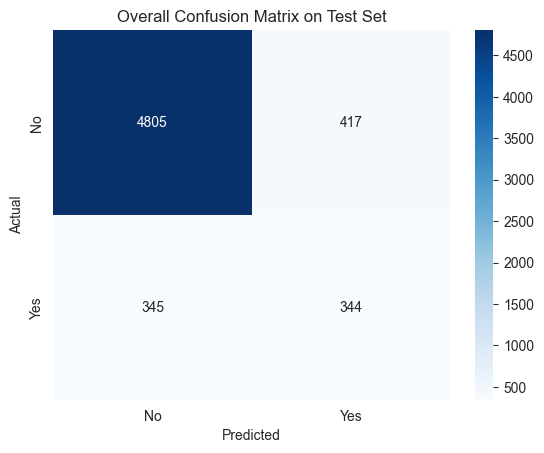

In [ ]:
print("\n==================  Applying Segmented Models to Full Test Set ==================")

# 1. Extract the optimal threshold for each cluster into a dictionary for easy lookup
thresholds_dict = summary_df.set_index('Cluster ID')['Best Threshold'].to_dict()

# 2. Create empty pandas Series to store the final predictions and probabilities.
#    Using the original y_test.index ensures perfect alignment.
y_test_final_preds = pd.Series(index=y_test.index, dtype=int)
y_test_final_probas = pd.Series(index=y_test.index, dtype=float)

# 3. Loop through each trained model and predict on its segment of the test set
for cluster_id, model in segment_models.items():
    print(f"--- Predicting for Cluster {cluster_id} ---")
    
    # Create a mask to find which test data points belong to this cluster
    test_mask = (X_test['cluster'] == cluster_id)
    
    # If no test samples fall into this cluster, skip it
    if not test_mask.any():
        print(f"No test samples found for Cluster {cluster_id}. Skipping.")
        continue
        
    # Select the subset of test data for this cluster
    # We don't need to reset the index here because we use the mask for alignment
    X_test_c = X_test[test_mask].drop(columns=['cluster'])
    
    # Predict probabilities using the cluster-specific model
    proba_c = model.predict_proba(X_test_c)[:, 1]
    
    # Get the unique, optimal threshold for this cluster
    threshold = thresholds_dict[cluster_id]
    print(f"Applying threshold: {threshold:.4f}")
    
    # Apply the threshold to get binary predictions
    preds_c = (proba_c >= threshold).astype(int)
    
    # Place the predictions and probabilities into our final Series using the mask
    y_test_final_preds[test_mask] = preds_c
    y_test_final_probas[test_mask] = proba_c

# 4. Now, evaluate the combined predictions against the true labels
print("\n\n==================  Overall Performance on Entire Test Set ==================")
print(classification_report(y_test, y_test_final_preds, target_names=['No Subscription', 'Subscription']))

# 5. Calculate and display the overall profit on the test set
# First, fill any potential NaN values with 0 and convert the Series to integers
y_test_final_preds = y_test_final_preds.fillna(0).astype(int)

# Define business metrics

# marketing_cost per call
# Affected by TP and FP --> we make call to both , 1.actual true and predicted true , 2. actual false but predicted true)
call_cost = 5.0  # (including labor & infrastructure)

# this cost are affect after customer Acquisition (agree for subscription)(only Affected by TP-actual true and predicted true )
# Onboarding & KYC verification cost
onboarding_cost = 5
#Account management costs(back-office ops, compliance)
acc_cost = 15
# Other overheads(like customer support): 
other_overheads = 10
total_customer_cost = onboarding_cost + acc_cost + other_overheads  # Total acquisition cost

# calculating revenue per costomer (only Affected by TP-actual true and predicted true )
# Average deposit amount = 4000
# Interest spread(Interest Earned by Bank on Loans or Investments − Interest Paid to Customer on Deposit) = 2.2% annually
# Customer holds deposit for 1 year
subscription_revenue = 88 # (4000 * 0.022)

# Calculate profit for every possible threshold 
precisions, recalls, thresholds = precision_recall_curve(y_validate, y_val_proba)

# To avoid division by zero
valid_precisions = np.maximum(precisions, 1e-8)
calls_made = (recalls * sum(y_validate)) / valid_precisions
#total profit = total_revenue - total_cost(cost of handling + marketing)
profit = (recalls * sum(y_validate) * subscription_revenue) - (recalls * sum(y_validate) * total_customer_cost) - (calls_made * call_cost)


# Find the threshold that corresponds to the maximum profit
best_threshold = thresholds[np.argmax(profit)]
print(f" Best Threshold for Max Profit: {best_threshold:.4f}")


# True positives and predicted positives at each point
total_pos = sum(y_validate)
TP = recalls * total_pos
pred_pos = np.divide(TP, np.maximum(precisions, 1e-8)) 


# === Find Best Point ===
best_idx = np.argmax(profit)
print(f" Best Threshold: {best_threshold}")
print(f"Recall = {recalls[best_idx]:.3f}, Precision = {precisions[best_idx]:.3f}")
print(f"Calls Made = {int(pred_pos[best_idx])}, True Positives = {int(TP[best_idx])}")
print(f"Max Profit = ${profit[best_idx]:.2f}")

# 6. Display the final combined confusion matrix
cm = confusion_matrix(y_test, y_test_final_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Overall Confusion Matrix on Test Set')
plt.show()